<a href="https://colab.research.google.com/github/maetthil/NASASpaceApps/blob/main/Read_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%%capture
!pip install cdflib
!pip install pyspedas
!pip install matplotlib==3.1.2

In [2]:
import glob
import cdflib 
import sys
import os
import requests
import pytz
import datetime
import pandas as pd
from bs4 import BeautifulSoup as bs
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [3]:
DATASET_PATH = 'dataset/'

In [4]:
def download_bwt_file(days, month, year='2022', data='wind', n=10):
    def get_links(days, month, year, url, filename):
        url = os.path.join(url, str(year))
        links = []
        if month < 10:
            month = f'0{month}'
        for d in days:
            if d < 10:
                timestamp = f'{year}{month}0{d}'
            else:
                timestamp = f'{year}{month}0{d}'
                
            f = filename.format(timestamp)
            link = os.path.join(url, f)
            links.append(link)
        return links

    if data == 'dscovr':
        url = 'https://cdaweb.gsfc.nasa.gov/pub/data/dscovr/h0/mag/'
        filename = 'dscovr_h0_mag_{}_v01.cdf'
    elif data == 'wind':
        url = 'https://cdaweb.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/'
        filename = 'wi_h2_mfi_{}_v04.cdf'
    elif data == 'wind_ion':
        url = 'https://cdaweb.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/'
        filename = 'wi_h1_swe_{}_v01.cdf'
    else:
        raise Exception('Conjunto de dados desconhecido')
    content = requests.get(url).content
    DATA_FOLDER = 'dataset/'
    if not os.path.exists(os.path.join(DATA_FOLDER, data)):
        os.makedirs(os.path.join(DATA_FOLDER, data))
    downloaded = 0
    for link in tqdm(get_links(days=days, month=month, 
                               year=year, url=url, filename=filename)):
        filename = os.path.basename(link)
        if downloaded == n:
            break
        response = requests.get(link)
        with open(f'{DATA_FOLDER}{data}/{filename}', 'wb') as f:
            f.write(response.content)
        downloaded += 1


def load_cdf_files(data='wind'):
    if data == 'dscovr':
        base = 'dataset/dscovr/'
    elif data == 'wind':
        base = 'dataset/wind/'
    elif data == 'wind_ion':
        base = 'dataset/wind_ion/'
    else:
        raise Exception('Conjunto de dados desconhecido')
    files = glob.glob(os.path.join(base, '*.cdf'))
    for f in files:
        yield cdflib.cdf_to_xarray(f)

In [5]:
download_bwt_file(days=range(1, 11), month=6, year=2022, data='wind')

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
download_bwt_file(days=range(1, 11), month=6, year=2022, data='dscovr')

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
download_bwt_file(days=range(1, 11), month=6, year=2022, data='wind_ion')

  0%|          | 0/10 [00:00<?, ?it/s]

## Leitura de dados

In [8]:
dscovr_ds = load_cdf_files(data='dscovr')
wind_ds = load_cdf_files(data='wind')
wind_ion_ds = load_cdf_files(data='wind_ion')

In [9]:
dscovr = next(dscovr_ds)
wind = next(wind_ds)
wind_ion = next(wind_ion_ds)

In [13]:
dscovr

<xarray.Dataset>
Dimensions:       (Epoch1: 86400, unit_time: 3, dim0: 3, dim1: 8)
Coordinates:
  * Epoch1        (Epoch1) float64 6.382e+13 6.382e+13 ... 6.382e+13 6.382e+13
  * unit_time     (unit_time) <U4 'year' 'day ' 'msec'
    label_time    (unit_time) <U27 'Year                       ' ... 'Elapsed...
Dimensions without coordinates: dim0, dim1
Data variables: (12/17)
    Time1_PB5     (Epoch1, unit_time) int32 2022 154 500 ... 2022 154 86399500
    NUM1_PTS      (Epoch1) int32 50 50 50 50 50 50 50 ... 50 50 50 50 50 50 50
    B1F1          (Epoch1) float32 3.804 3.761 3.771 3.796 ... 3.675 3.685 3.693
    B1SDF1        (Epoch1) float32 0.03651 0.04095 0.05156 ... 0.0424 0.03963
    B1GSE         (Epoch1, dim0) float32 0.4879 -3.301 -1.826 ... -3.114 -0.8405
    B1SDGSE       (Epoch1, dim0) float32 0.05367 0.02987 ... 0.03572 0.05762
    ...            ...
    SENS          (dim0, dim1) float32 -1e+31 0.008067 -1e+31 ... -1e+31 -1e+31
    format_time   (dim0) <U2 'I4' 'I3' 'I8'
    label_bgse    (dim0) <U8 'Bx (GSE)' 'By (GSE)' 'Bz (GSE)'
    label_bsdgse  (dim0) <U14 'Bx_SIGMA (GSE)' 'By_SIGMA (GSE)' 'Bz_SIGMA (GSE)'
    label_brtn    (dim0) <U8 'Br (RTN)' 'Bt (RTN)' 'Bn (RTN)'
    label_bsdrtn  (dim0) <U14 'Br_SIGMA (RTN)' 'Bt_SIGMA (RTN)' 'Bn_SIGMA (RTN)'
Attributes: (12/21)
    Project:                     DSCOVR>Deep Space Climate Observatory
    Discipline:                  Space Physics>Heliospheric Science
    Source_name:                 DSCOVR>Deep Space Climate Observatory
    Software_version:            V01.00
    Data_type:                   H0>1-sec Definitive Data
    Descriptor:                  MAG>Fluxgate Magnetometer
    ...                          ...
    PI_name:                     A. Koval
    PI_affiliation:              UMBC, NASA/GSFC
    Mission_group:               DSCOVR
    Instrument_type:             Magnetic Fields (space)
    TEXT_supplement_1:            
    Web_sites:

In [14]:
wind

<xarray.Dataset>
Dimensions:      (Epoch: 935080, unit_time: 3, dim0: 3, Epoch1: 1440, dim1: 8)
Coordinates:
  * Epoch        (Epoch) float64 6.382e+13 6.382e+13 ... 6.382e+13 6.382e+13
  * Epoch1       (Epoch1) float64 6.382e+13 6.382e+13 ... 6.382e+13 6.382e+13
  * unit_time    (unit_time) <U4 'year' 'day ' 'msec'
    label_time   (unit_time) <U27 'Year                       ' ... 'Elapsed ...
Dimensions without coordinates: dim0, dim1
Data variables: (12/26)
    Time_PB5     (Epoch, unit_time) int32 2022 157 21 2022 ... 2022 157 86399972
    BF1          (Epoch) float32 5.271 5.285 5.264 5.255 ... 8.809 8.808 8.772
    BGSM         (Epoch, dim0) float32 2.867 -0.1516 -4.42 ... -5.233 -3.852
    BGSE         (Epoch, dim0) float32 2.866 -1.36 -4.209 ... -6.074 -2.308
    RANGE        (Epoch) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    SPC_MODE     (Epoch) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ...           ...
    PAYLD1_I     (Epoch1, dim0, dim0) float64 1.0 0.0 0.0 0.0 ... 0.0 0.0 -1.0
    FLAG1_I      (Epoch1) int32 5 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5 5 5
    format_time  (dim0) <U2 'I4' 'I3' 'I8'
    label_bgsm   (dim0) <U8 'Bx (GSM)' 'By (GSM)' 'Bz (GSM)'
    label_bgse   (dim0) <U8 'Bx (GSE)' 'By (GSE)' 'Bz (GSE)'
    cartesian    (dim0) <U11 'x-component' 'y-component' 'z-component'
Attributes: (12/28)
    Project:                     ISTP>International Solar-Terrestrial Physics
    Discipline:                  Space Physics>Heliospheric Science
    Source_name:                 WIND>Wind Interplanetary Plasma Laboratory
    Software_version:            V05.00
    Data_type:                   H2>High-resolution Definitive Data
    Descriptor:                  MFI>Magnetic Fields Investigation
    ...                          ...
    PI_name:                     A. Koval
    PI_affiliation:              UMBC, NASA/GSFC
    Mission_group:               Wind
    Instrument_type:             Magnetic Fields (space)
    TEXT_supplement_1:            
    Web_sites:                   http://wind.nasa.gov

In [15]:
wind_ion

<xarray.Dataset>
Dimensions:                   (Epoch: 800)
Coordinates: (12/20)
  * Epoch                     (Epoch) float64 6.382e+13 6.382e+13 ... 6.382e+13
    Proton_sigmaV_nonlin      (Epoch) float32 11.41 11.35 11.3 ... 8.411 8.39
    Proton_sigmaVX_nonlin     (Epoch) float32 11.45 11.39 11.34 ... 8.412 8.391
    Proton_sigmaVY_nonlin     (Epoch) float32 3.065 3.0 3.291 ... 1.0 1.0 1.0
    Proton_sigmaVZ_nonlin     (Epoch) float32 2.478 2.178 1.89 ... 1.0 1.0 1.0
    Proton_sigmaW_nonlin      (Epoch) float32 1.356 1.332 1.483 ... 1.115 1.977
    ...                        ...
    Alpha_sigmaVZ_nonlin      (Epoch) float32 27.62 28.65 25.44 ... 1.0 1.822
    Alpha_sigmaW_nonlin       (Epoch) float32 1.356 1.332 1.483 ... 1.115 1.977
    Alpha_sigmaWperp_nonlin   (Epoch) float32 1e+05 1e+05 1e+05 ... 1.833 1e+05
    Alpha_sigmaWpar_nonlin    (Epoch) float32 1e+05 1e+05 1e+05 ... 9.749 1e+05
    Alpha_sigmaNa_nonlin      (Epoch) float32 0.01 0.01 0.01 ... 0.01 0.01 0.01
    sigmaPeak_doy             (Epoch) float64 4.424e-05 4.424e-05 ... 5.898e-05
Data variables: (12/41)
    fit_flag                  (Epoch) int8 10 10 10 10 10 10 ... 10 10 10 10 10
    year                      (Epoch) int8 -26 -26 -26 -26 ... -26 -26 -26 -26
    doy                       (Epoch) float32 153.0 153.0 153.0 ... 154.0 154.0
    Proton_V_nonlin           (Epoch) float32 366.7 366.0 367.9 ... 356.3 350.6
    Proton_VX_nonlin          (Epoch) float32 -365.3 -364.7 ... -356.3 -350.5
    Proton_VY_nonlin          (Epoch) float32 -23.57 -23.19 ... -3.985 -6.643
    ...                        ...
    dev                       (Epoch) float32 0.01289 0.01392 ... 0.03966
    xgse                      (Epoch) float32 218.9 218.9 218.9 ... 219.9 219.9
    ygse                      (Epoch) float32 102.8 102.8 102.8 ... 103.4 103.4
    zgse                      (Epoch) float32 -0.04873 -0.04823 ... 0.3761
    ygsm                      (Epoch) float32 98.05 98.07 98.08 ... 98.72 98.73
    zgsm                      (Epoch) float32 30.78 30.73 30.68 ... 30.92 30.87
Attributes: (12/19)
    Project:                     WIND/SWE Faraday Cup (Proton - Alpha Anisotr...
    Source_name:                 Wind
    Discipline:                  ['Space Physics>Magnetospheric Science', 'Sp...
    Data_type:                   VS>Validated Summary Data
    Descriptor:                  SWE>Solar Wind Experiment
    File_naming_convention:      source_datatype_descriptor
    ...                          ...
    Logical_file_id:             wi_h1_swe_20220602_v01
    Logical_source_description:  Solar wind proton and alpha parameters, incl...
    Time_resolution:             92 seconds
    Generated_by:                Michael L. Stevens (mstevens@cfa.harvard.edu)
    Generation_date:             Thu Sep  8 13:58:35 2022
    MODS:                        data analysis package revised March, 2012.

## Step one

In [16]:
magnetic_field_wind = wind["BGSM"]
magnetic_field_dscovr = dscovr["B1GSE"]


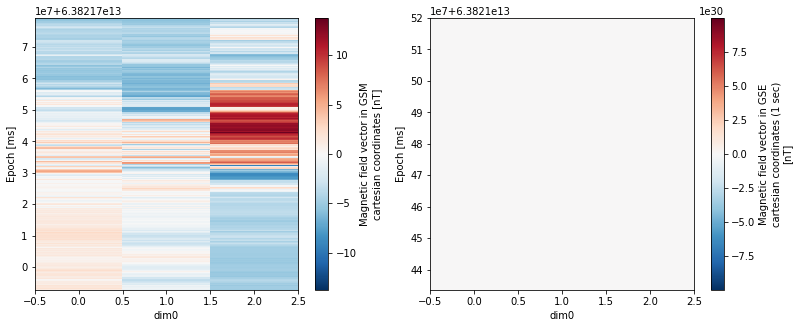

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13, 5))
fig.add_subplot(1, 2, 1)
magnetic_field_wind.plot()
fig.add_subplot(1, 2, 2)
magnetic_field_dscovr.plot()
plt.show()

## Step two

## Step three

In [ ]:
#Ion parameters we need
# density n(D(t))
# temperature w(D(t))
# velocity n(D(t))